[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [3]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

In [1]:
import os
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy-ragtest"

from dotenv import load_dotenv

# 指定 .env 文件路径
env_path = r'C:\GitRepo\langchain-academy\module-1\.env'

# 加载 .env 文件
load_dotenv(dotenv_path=env_path)

from langchain_openai import AzureChatOpenAI, ChatOpenAI

model = AzureChatOpenAI(
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [15]:
from langgraph.graph import MessagesState
class StateWithSummary(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [28]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: StateWithSummary):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"
        print(f"这一轮在system_message中带上了总结: {system_message}")
        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [29]:
def summarize_conversation(state: StateWithSummary):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [30]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: StateWithSummary):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

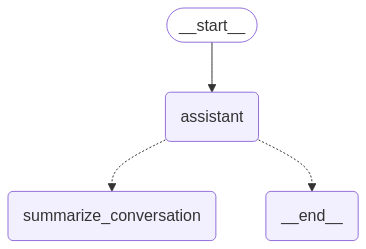

In [31]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Graph
builder = StateGraph(StateWithSummary)

# Define nodes: these do the work
builder.add_node("summarize_conversation", summarize_conversation)
builder.add_node("assistant", call_model)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
)

# graph = builder.compile()

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [32]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Hello, my name is Joey.")]

# Run
messages = graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Joey.
================================== Ai Message ==================================

Hello, Joey! 😊 It's great to meet you. How can I assist you today?


In [33]:
# Specify an input
messages = [HumanMessage(content="Say my name.")]

# Run
messages = graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Joey.
================================== Ai Message ==================================

Hello, Joey! 😊 It's great to meet you. How can I assist you today?
================================ Human Message =================================

Say my name.
================================== Ai Message ==================================

Of course, Joey! 😊 What’s on your mind?


In [34]:
# Specify an input
messages = [HumanMessage(content="Say my name in Chinese.")]

# Run
messages = graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Say my name in Chinese.
================================== Ai Message ==================================

Sure, Joey! Your name in Chinese would typically be transliterated as **乔伊** (Qiáo Yī).  

- **乔 (Qiáo)** captures the "Jo" sound.  
- **伊 (Yī)** represents the "ey" sound.  

Let me know if you'd like to learn more about Chinese or anything else! 😊


In [35]:
messages['summary']

"Sure! Here's a summary of our conversation:\n\nJoey introduced himself, and I greeted him warmly. Joey then asked me to say his name, which I did. He later requested his name in Chinese, and I provided the transliteration as **乔伊 (Qiáo Yī)**, explaining how it corresponds to the sounds in his name. 😊"

In [36]:
# Specify an input
messages = [HumanMessage(content="Say my name in zh-cn trans.")]

# Run
messages = graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

这一轮在system_message中带上了总结: Summary of conversation earlier: Sure! Here's a summary of our conversation:

Joey introduced himself, and I greeted him warmly. Joey then asked me to say his name, which I did. He later requested his name in Chinese, and I provided the transliteration as **乔伊 (Qiáo Yī)**, explaining how it corresponds to the sounds in his name. 😊
================================ Human Message =================================

Say my name in Chinese.
================================== Ai Message ==================================

Sure, Joey! Your name in Chinese would typically be transliterated as **乔伊** (Qiáo Yī).  

- **乔 (Qiáo)** captures the "Jo" sound.  
- **伊 (Yī)** represents the "ey" sound.  

Let me know if you'd like to learn more about Chinese or anything else! 😊
================================ Human Message =================================

Say my name in zh-cn trans.
================================== Ai Message ==================================

Sure! In **

In [37]:
messages['summary']

"Sure! Here's a summary of our conversation:\n\nJoey introduced himself, and I greeted him warmly. Joey then asked me to say his name, which I did. He later requested his name in Chinese, and I provided the transliteration as **乔伊 (Qiáo Yī)**, explaining how it corresponds to the sounds in his name. 😊"

In [38]:
messages['messages']

[HumanMessage(content='Say my name in Chinese.', additional_kwargs={}, response_metadata={}, id='b91891e9-f899-4cbe-bfb5-6d066de9f328'),
 AIMessage(content='Sure, Joey! Your name in Chinese would typically be transliterated as **乔伊** (Qiáo Yī).  \n\n- **乔 (Qiáo)** captures the "Jo" sound.  \n- **伊 (Yī)** represents the "ey" sound.  \n\nLet me know if you\'d like to learn more about Chinese or anything else! 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 70, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BLo76U7evCR4Azkhgb6GcTbPz0s5w', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe

In [39]:
# Specify an input
messages = [HumanMessage(content="what did we discuss before? reply in Chinese.")]

# Run
messages = graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

这一轮在system_message中带上了总结: Summary of conversation earlier: Sure! Here's a summary of our conversation:

Joey introduced himself, and I greeted him warmly. Joey then asked me to say his name, which I did. He later requested his name in Chinese, and I provided the transliteration as **乔伊 (Qiáo Yī)**, explaining how it corresponds to the sounds in his name. 😊
================================ Human Message =================================

what did we discuss before? reply in Chinese.
================================== Ai Message ==================================

当然可以！我们之前讨论了你的名字。我告诉你，你的名字“Joey”在中文里可以翻译为**乔伊 (Qiáo Yī)**，并解释了这个翻译是如何对应你名字的发音的。😊


# ====================================

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

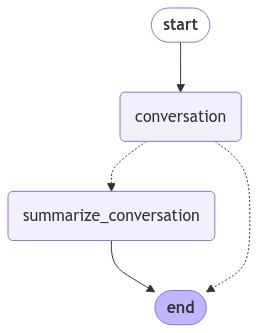

In [10]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [42]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph_memory.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph_memory.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph_memory.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! 😊 Nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Lance! 😊
================================== Ai Message ==================================

That's awesome, Lance! 🏈 The 49ers are such a legendary team with a rich history. Are you excited about how they're doing this season, or do you have a favorite player? Let’s talk Niners! 😊


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [44]:
graph_memory.get_state(config).values.get("summary","")

"Sure! Here's a summary of our conversation:\n\nLance introduced himself and shared that he likes the San Francisco 49ers. I responded enthusiastically, acknowledged his name, and expressed excitement about his interest in the team, asking if he had a favorite player or thoughts on their season. 😊"

The `config` with thread ID allows us to proceed from the previously logged state!

In [45]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph_memory.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

这一轮在system_message中带上了总结: Summary of conversation earlier: Sure! Here's a summary of our conversation:

Lance introduced himself and shared that he likes the San Francisco 49ers. I responded enthusiastically, acknowledged his name, and expressed excitement about his interest in the team, asking if he had a favorite player or thoughts on their season. 😊
================================== Ai Message ==================================

Yes, you're absolutely right, Lance! Nick Bosa is a beast on the field, and he became the highest-paid defensive player in NFL history after signing that massive contract extension with the 49ers. 💰💪 His deal was worth **$170 million over five years**, with **$122.5 million guaranteed**—crazy numbers, right? But he totally deserves it with how dominant he is as a pass rusher.

Are you a fan of his sack celebrations, or do you just love how he wrecks opposing offenses? 😄


In [46]:
graph_memory.get_state(config).values.get("summary","")

"Sure! Here's a summary of our conversation:\n\nLance introduced himself and shared that he likes the San Francisco 49ers. I responded enthusiastically, acknowledged his name, and expressed excitement about his interest in the team, asking if he had a favorite player or thoughts on their season. 😊"

## LangSmith

Let's review the trace!